In [30]:
#### calculate consistency among different groups of neurons

import numpy as np
import os
import matplotlib.pyplot as plt

import import_ipynb
import func_format
import func_analysis

import scipy as sp
from scipy import stats

In [31]:
def extractusableint(modality, intcat, foldername, presentationnumber):
    if modality == 'female':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Female']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Female']
    elif modality == 'male':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
    elif modality == 'object':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
    elif modality == 'food':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Food']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Food']
    elif modality == 'social':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Female'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Female'])
    elif modality == 'nonsocial':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Food'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Food'])
    elif modality == 'panresponsive':
        usableint = foldername
        usablepresentationnumber = presentationnumber
    else:
        usableint = foldername
        usablepresentationnumber = presentationnumber
    
    return(usableint, usablepresentationnumber)

def pearson_noNANpairs(reorderedROC):
    reorderedROC = (np.array(reorderedROC, np.float)-.5)*2

    for j, column in enumerate(reorderedROC):
        column1values = np.array(column[1:], dtype = np.float32)
        outputr = []
        outputp = []

        for k, column2 in enumerate(reorderedROC):
            columncompare = np.array(column2[1:], dtype = np.float32)
            combine = np.vstack((column1values, columncompare)).T
            [row, col] = np.where(np.isnan(combine) == True)
            nonans = np.delete(combine, np.unique(row), axis = 0)
            [pearsonr, pvalue] = stats.pearsonr(nonans[:,0], nonans[:,1])

            outputr = np.append(outputr, pearsonr)
            outputp = np.append(outputp, pvalue)

        if j == 0:
            pearsonrall = outputr
            pvalueall = outputp
        else:
            pearsonrall = np.vstack((pearsonrall, outputr))
            pvalueall = np.vstack((pvalueall, outputp))
            
    return(pearsonrall, pvalueall)

In [32]:
### BMA plot

responseprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/BMA_responsetype_day1.csv', delimiter = ',', dtype = str)

unimodal = responseprofile[responseprofile[:,3] == 'unimodal']
panresponsive = responseprofile[responseprofile[:,3] == 'multimodal']

allresponsive = np.vstack((unimodal, panresponsive))

In [33]:
order = ['Female1', 'Female2', 'NovelMale1', 'NovelMale2']

for i, row in enumerate(allresponsive):
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    
    ROCscores = np.loadtxt('F:/'+row[0]+'/Analyses/'+row[1]+'/ROC_BMA/ROCscores.csv', delimiter = ',', dtype = str)
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    neuronROC = np.ravel(ROCscores[ROCscores[:,0] == row[2]])
    
    for j, item in enumerate(order):
        index = np.where(np.ravel(inttype) == order[j])
        values = neuronROC[1:][index]
        #values2 = neuronROCafter[1:][index]
        #values[values == 'nan'] = .5
        if len(values) == 1:
            values = np.append(values, np.nan)
        #if len(values2) == 1:
            #values2 = np.append(values2, np.nan)
        if len(values) == 0:
            values = [np.nan, np.nan]
        #if len(values2) == 0:
            #values2 = [np.nan, np.nan]
            
        if j == 0:
            ROClist = values
        else:
            ROClist = np.hstack((ROClist, values))
    if i == 0:
        save = ROClist
        neuronID = row[:5]
    else:
        save = np.vstack((save, ROClist))
        neuronID = np.vstack((neuronID, row[:5]))
        
interaction = pearson_noNANpairs(save.T)

<ipython-input-34-4ac44ba6d07d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)


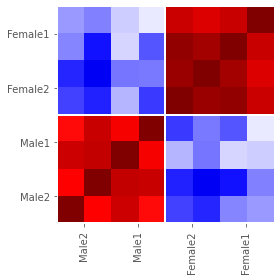

In [34]:
plt.close()
fig, ax = plt.subplots(1, figsize = (4, 4))
cb = ax.pcolormesh(interaction[0], vmin = -1, vmax = 1, cmap = 'seismic')
ax.grid(False)
ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)
ax.set_xticks((1, 3, 5, 7, 9, 11))
ax.set_yticks((1, 3, 5, 7, 9, 11))
ax.set_yticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'))
ax.set_xlim(len(interaction[0]), 0)
ax.set_ylim(len(interaction[0]), 0)

ax.hlines(4, 16, -.5, lw = 2, color = 'white')
ax.hlines(8, 16, -.5, lw = 2, color = 'white')
ax.hlines(10, 16, -.5, lw = 2, color = 'white')
#ax.hlines(11.5, 16, -.5, lw = 2, color = 'white')
ax.vlines(4, 16, -.5, lw = 2, color = 'white')
ax.vlines(8, 16, -.5, lw = 2, color = 'white')
ax.vlines(10, 16, -.5, lw = 2, color = 'white')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure2/F2_BMAPopulationCorrelation.png', dpi = 300)
plt.savefig('F:/Figure2/F2_BMAPopulationCorreation.svg', format = 'svg', dpi = 500, transparent = True)

In [35]:
### BA plot

responseprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/BA_responsetype_day1.csv', delimiter = ',', dtype = str)

unimodal = responseprofile[responseprofile[:,3] == 'unimodal']
panresponsive = responseprofile[responseprofile[:,3] == 'multimodal']

allresponsive = np.vstack((unimodal, panresponsive))

In [36]:
order = ['Female1', 'Female2', 'NovelMale1', 'NovelMale2']

for i, row in enumerate(allresponsive):
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    
    ROCscores = np.loadtxt('F:/'+row[0]+'/Analyses/'+row[1]+'/ROC_BA/ROCscores.csv', delimiter = ',', dtype = str)
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    neuronROC = np.ravel(ROCscores[ROCscores[:,0] == row[2]])
    
    for j, item in enumerate(order):
        index = np.where(np.ravel(inttype) == order[j])
        values = neuronROC[1:][index]
        #values2 = neuronROCafter[1:][index]
        #values[values == 'nan'] = .5
        if len(values) == 1:
            values = np.append(values, np.nan)
        #if len(values2) == 1:
            #values2 = np.append(values2, np.nan)
        if len(values) == 0:
            values = [np.nan, np.nan]
        #if len(values2) == 0:
            #values2 = [np.nan, np.nan]
            
        if j == 0:
            ROClist = values
        else:
            ROClist = np.hstack((ROClist, values))
    if i == 0:
        save = ROClist
        neuronID = row[:5]
    else:
        save = np.vstack((save, ROClist))
        neuronID = np.vstack((neuronID, row[:5]))
        
interaction = pearson_noNANpairs(save.T)

<ipython-input-37-96c1bd0922ae>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)


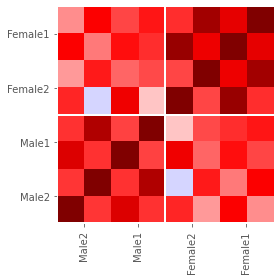

In [37]:
plt.close()
fig, ax = plt.subplots(1, figsize = (4, 4))
cb = ax.pcolormesh(interaction[0], vmin = -1, vmax = 1, cmap = 'seismic')
ax.grid(False)
ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)
ax.set_xticks((1, 3, 5, 7, 9, 11))
ax.set_yticks((1, 3, 5, 7, 9, 11))
ax.set_yticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'))
ax.set_xlim(len(interaction[0]), 0)
ax.set_ylim(len(interaction[0]), 0)

ax.hlines(4, 16, -.5, lw = 2, color = 'white')
ax.hlines(8, 16, -.5, lw = 2, color = 'white')
ax.hlines(10, 16, -.5, lw = 2, color = 'white')
#ax.hlines(11.5, 16, -.5, lw = 2, color = 'white')
ax.vlines(4, 16, -.5, lw = 2, color = 'white')
ax.vlines(8, 16, -.5, lw = 2, color = 'white')
ax.vlines(10, 16, -.5, lw = 2, color = 'white')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure2/F2_BAPopulationCorrelation.png', dpi = 300)
plt.savefig('F:/Figure2/F2_BAPopulationCorrelation.svg', format = 'svg', dpi = 500, transparent = True)

In [38]:
### LA plot

responseprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/LA_responsetype_day1.csv', delimiter = ',', dtype = str)

unimodal = responseprofile[responseprofile[:,3] == 'unimodal']
panresponsive = responseprofile[responseprofile[:,3] == 'multimodal']

allresponsive = np.vstack((unimodal, panresponsive))

In [39]:
order = ['Female1', 'Female2', 'NovelMale1', 'NovelMale2']

for i, row in enumerate(allresponsive):
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    
    ROCscores = np.loadtxt('F:/'+row[0]+'/Analyses/'+row[1]+'/ROC_LA/ROCscores.csv', delimiter = ',', dtype = str)
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    neuronROC = np.ravel(ROCscores[ROCscores[:,0] == row[2]])
    
    for j, item in enumerate(order):
        index = np.where(np.ravel(inttype) == order[j])
        values = neuronROC[1:][index]
        #values2 = neuronROCafter[1:][index]
        #values[values == 'nan'] = .5
        if len(values) == 1:
            values = np.append(values, np.nan)
        #if len(values2) == 1:
            #values2 = np.append(values2, np.nan)
        if len(values) == 0:
            values = [np.nan, np.nan]
        #if len(values2) == 0:
            #values2 = [np.nan, np.nan]
            
        if j == 0:
            ROClist = values
        else:
            ROClist = np.hstack((ROClist, values))
    if i == 0:
        save = ROClist
        neuronID = row[:5]
    else:
        save = np.vstack((save, ROClist))
        neuronID = np.vstack((neuronID, row[:5]))
        
interaction = pearson_noNANpairs(save.T)

<ipython-input-40-38ee562b8813>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)


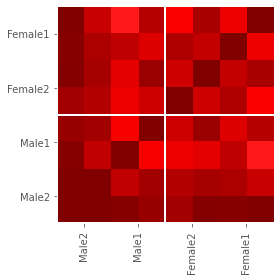

In [40]:
plt.close()
fig, ax = plt.subplots(1, figsize = (4, 4))
cb = ax.pcolormesh(interaction[0], vmin = -1, vmax = 1, cmap = 'seismic')
ax.grid(False)
ax.set_xticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'), rotation = 90)
ax.set_xticks((1, 3, 5, 7, 9, 11))
ax.set_yticks((1, 3, 5, 7, 9, 11))
ax.set_yticklabels(('Female1', 'Female2', 'Male1', 'Male2', 'Object', 'Food'))
ax.set_xlim(len(interaction[0]), 0)
ax.set_ylim(len(interaction[0]), 0)

ax.hlines(4, 16, -.5, lw = 2, color = 'white')
ax.hlines(8, 16, -.5, lw = 2, color = 'white')
ax.hlines(10, 16, -.5, lw = 2, color = 'white')
#ax.hlines(11.5, 16, -.5, lw = 2, color = 'white')
ax.vlines(4, 16, -.5, lw = 2, color = 'white')
ax.vlines(8, 16, -.5, lw = 2, color = 'white')
ax.vlines(10, 16, -.5, lw = 2, color = 'white')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure2/F2_LAPopulationCorrelation.png', dpi = 300)
plt.savefig('F:/Figure2/F2_LAPopulationCorrelation.svg', dpi = 500, format = 'svg', transparent = True)